In [67]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Network

## Components in network: switch, link and server

In [68]:
class Node:
    def __hash__(self):
        return hash(self.name)

    def __init__(self, name, type, delay = 0.0, capacity = None,cost = None, used=None, VNFs=None):
        self.name = name                # name Node
        self.type = type                # type Node (1:switch node; 2:MDC node)
        self.cap = capacity             # capacity of Node {type=1: memory_capacity, type=2: cpu_capacity, type=3: ram_capacity} 
            # format
            # capacity = {
            #     "mem_capacity": 0.0,
            #     "cpu_capacity": 0.0,
            #     "ram_capacity": 0.0
            # }
        self.delay  = delay             # delay of server
        if used == None:
            self.used ={
                0: {
                    "mem_used": 0.0,
                    "cpu_used": 0.0,
                    "ram_used":0.0
                }
            }
        else:
            self.used = used
            # format
            # used = {
            #     timeslot:{
            #         "mem_used": 0.0,
            #         "cpu_used": 0.0,
            #         "ram_used": 0.0
            #     }
            # }         
        self.links = []            
    
        if VNFs is None:               # VNF exist in Node (possible with type=2) example [1,2,3]
            self.VNFs = set()
        else:
            self.VNFs = VNFs 
        
        self.cost = cost                # cost of server
        # format
        # cost = {
        #     "cost_c" : 0.0,
        #     "cost_r":  0.0,
        #     "cost_h": 0.0
        # }               

    # check how much memory or cpu used exceed the capacity
    # pass param > 0 if wanting to try without using
    def violated(self, res=0.0):
        return (self.used + res) > self.cap

    # check the existence of VNF in the current node
    def has_VNF(self, VNF):
        return self.type == 2 and VNF in self.VNFs

    # add VNF
    def add_VNF(self, VNF):
        if not self.has_VNF(VNF):
            self.VNFs.add(VNF)
            return True
        return False

    # add VNF
    def remove_VNF(self, VNF):
        if self.has_VNF(VNF):
            self.VNFs.remove(VNF)

    # add used memory or cpu (subtract if passing a negative value)
    def use(self, res):
        self.used += res
        
    # add used memory, cpu and ram of request at slot time T
    def add_used(self, T, used_res):
        if T in self.used:
            self.used[T]["mem_used"] += used_res["mem_used"]
            self.used[T]["cpu_used"] += used_res["cpu_used"]
            self.used[T]["ram_used"] += used_res["ram_used"]
        else:
            self.used[T] ={}
            self.used[T]["mem_used"] = used_res["mem_used"]
            self.used[T]["cpu_used"] = used_res["cpu_used"]
            self.used[T]["ram_used"] = used_res["ram_used"]            


class Link:
    def __hash__(self):
        return hash((self.u.name, self.v.name))

    def __init__(self, u, v, bandwidth_capacity,link_delay, used=None):
        self.u = u  # first node
        self.v = v  # second node
        self.cap = bandwidth_capacity
        self.link_delay = link_delay
        if used == None:
            self.used ={
                0: 0.0
            } 
        else: 
            self.used = used

    # get the next node if a node go through this link
    def next(self, node):
        return self.u if node is self.v else \
            (self.v if node is self.u else None)

    # check violated bandwidth
    def violated(self, res=0.0):
        return (self.used + res) > self.cap

    # add used bandwidth
    def use(self, bandwidth):
        self.used += bandwidth
    
    def add_used(self, T, used_bandwidth):
        if T in self.used:
            self.used[T] += used_bandwidth
        else:
            self.used[T] = used_bandwidth

## Network

In [69]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


class Network:
    def __init__(self, VNF_costs=None):
        self._max_cpu = None
        self._max_memory = None
        self._max_bandwidth = None
        self.nodes = {}  # list of all nodes (switch + MDC)
        self.links = []  # list of connections
        self.VNF_costs = VNF_costs

    # list of switch nodes
    @property
    def switch_nodes(self):
        return [node for node in self.nodes.values() if node.type == 1]

    # add a switch node to network
    def add_switch_node(self, name):
        node = Node(name, 1)
        self.nodes[name] = node

    # list of MDC nodes
    @property
    def MDC_nodes(self):
        return [node for node in self.nodes.values() if node.type == 2]

    # add a MDC node to network
    def add_MDC_node(self, name, delay, capacity,used = None, VNFs=None, cost = None):
        node = Node(name, 2, delay, capacity, used, VNFs, cost)
        self.nodes[name] = node

    # add a connection
    def add_link(self, u, v, bandwidth_capacity, link_delay, used = None):
        u = self.nodes[u]
        v = self.nodes[v]
        link  = Link(u, v, bandwidth_capacity, link_delay, used)
        self.links.append(link)
        link.u.links.append(link)
        link.v.links.append(link)
        
    
    def violated_bandwidth(self):
        return sum([link.violated() for link in self.links])

    def violated_memory(self):
        return sum([node.violated() for node in self.switch_nodes])

    def violated_cpu(self):
        return sum([node.violated() for node in self.MDC_nodes])

    # @property
    # def max_bandwidth(self):
    #     if self._max_bandwidth is None:
    #         self._max_bandwidth = max([link.cap for link in self.links])
    #     return self._max_bandwidth

    # @property
    # def max_memory(self):
    #     if self._max_memory is None:
    #         self._max_memory = max([node.cap for node in self.switch_nodes])
    #     return self._max_memory

    # @property
    # def max_cpu(self):
    #     if self._max_cpu is None:
    #         self._max_cpu = max([node.cap for node in self.MDC_nodes])
    #     return self._max_cpu

    # # Bandwidth usage level in link
    # def max_used_bandwidth(self):
    #     return max([link.used / link.cap for link in self.links])
    # # Memory usage level in switch node
    # def max_used_memory(self):
    #     return max([node.used / node.cap for node in self.switch_nodes])
    
    # # CPU usage level in MDC node
    # def max_used_cpu(self):
    #     return max([node.used / node.cap for node in self.MDC_nodes])

    # def validate(self):
    #     return self.violated_bandwidth() + self.violated_cpu() + self.violated_memory() <= 1e-9

    def to_graph(self):
        G = nx.Graph()
        for node in self.nodes.values():
            G.add_node(node.name, type=node.type, cap=node.cap, used=node.used, VNFs=node.VNFs)
        for link in self.links:
            G.add_edge(link.u.name, link.v.name, cap=link.cap, used=link.used)
        return G

    def visualize(self, pos_path=None, info=False, topo=False, out_path=None):
        G = self.to_graph()

        if pos_path is None:
            pos_nodes = nx.spring_layout(G)
        else:
            df = pd.read_csv(pos_path, skiprows=1)
            pos_nodes = df.to_numpy()
            pos_nodes[:, 1] = -pos_nodes[:, 1]
            pos_nodes = {str(i): coord for i, coord in enumerate(pos_nodes)}

        if topo:
            colors = ['blue' if G.nodes[node]['type'] == 1 else 'red' for node in G.nodes]
        else:
            colors = ['black']
        nx.draw(G, pos_nodes, node_size=30, node_color=colors, with_labels=True, font_size=5, font_color='white')

        if info:
            pos_attrs = {}
            for node, coords in pos_nodes.items():
                pos_attrs[node] = (coords[0], coords[1] + 10)

            node_attrs = {}
            for node in G.nodes:
                attrs = G.nodes[node]
                node_attrs[node] = str(attrs['used']) + '/' + str(attrs['cap'])
            nx.draw_networkx_labels(G, pos_attrs, labels=node_attrs, font_size=5)

            edge_attrs = {}
            for edge in G.edges:
                attrs = G.edges[edge]
                edge_attrs[edge] = str(attrs['used']) + '/' + str(attrs['cap'])
            nx.draw_networkx_edge_labels(G, pos_nodes, edge_labels=edge_attrs, font_size=5)
        if out_path is not None:
            plt.savefig(out_path)
        plt.show()


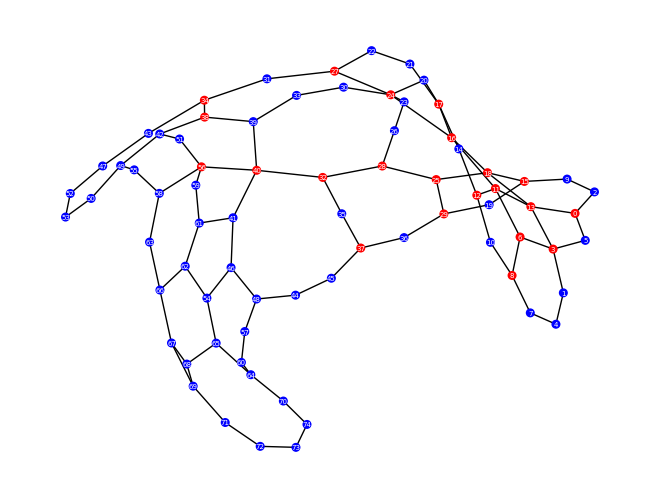

In [70]:
import json
network = Network()

with open(r'C:\Users\Admin\Documents\LAB\Virtural network\GP_Code\data\input\conus_urban_easy.json') as file:
    data = json.load(file)    
for node, value in data["V"].items():
    node = int(node)
    if value["server"] == True:
        capacity = {
            "memory_capacity": value["h_v"],
            "cpu_capacity": value["c_v"],
            "ram_capacity": value["r_v"]
        }
        cost = {
            "cost_c" : value["cost_c"],
            "cost_r":   value["cost_r"],
            "cost_h":  value["cost_h"]
        }
        network.add_MDC_node(node, value["d_v"], capacity, cost = cost)
    else:
        network.add_switch_node(node)
        
for link in data["E"]:
    network.add_link(link["u"], link["v"],link["b_l"], link["d_l"])
network.visualize(info=False, topo=True)